<a href="https://colab.research.google.com/github/Gurbnova/Edmonton-House-Predictions/blob/main/Edmonton_House_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Data Cleaning:
We will get rid of unnecessary columns and unusual data points in terms of:


*   Typical price per square foot threshold
*   Typical square footage per bedroom threshold
*   Typical number of bathrooms to number of bedrooms



In [313]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 10)

df1 = pd.read_csv("edmonton_housing_data_Feb15_2022.csv.zip", compression="zip")

df1.head()

,House Description,Price,Bedrooms,Bathrooms,Full Baths,Square Footage,Acres,Year Built,Type,Sub-Type,...,Bedrooms Above Grade,# of Garages,Garages,Half Baths,Fireplaces,Zoning,Lot Description,HOA Fees,HOA Fees Freq.,Condo Fee
0,"Rare property on the market, house converted t...","$399,990",1,1.0,1.0,787,0.12,1948,Single Family,Residential Detached Single Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,This fantastic family home has an option to As...,"$357,000",4,2.0,2.0,929,0.15,1954,Single Family,Residential Detached Single Family,...,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"At over 1150 square feet, this Allendale 3+2 b...","$499,600",5,2.0,2.0,"1,161",0.14,1959,Single Family,Residential Detached Single Family,...,3.0,1,7.32x4.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gorgeous upgrades and a lower level suite in C...,"$398,800",4,3.0,3.0,"1,217",0.15,1976,Single Family,Residential Detached Single Family,...,3.0,2,24x26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMAZING VALUE! Welcome home to this well-maint...,"$279,900",3,2.0,1.0,"1,160",0.00,1979,Single Family,Residential Detached Single Family,...,3.0,2,NaN,1.0,"Gas, Oak Surround",NaN,NaN,NaN,NaN,NaN


In [314]:
df1.shape

(1697, 52)

In [315]:
# Removing unnecessary  columns
df2 = df1.loc[:, ['Price', 'Bedrooms', 'Bathrooms', 'Square Footage', 'Community']]

df2.head()

,Price,Bedrooms,Bathrooms,Square Footage,Community
0,"$399,990",1,1.0,787,Glenwood
1,"$357,000",4,2.0,929,Woodcroft
2,"$499,600",5,2.0,"1,161",Allendale
3,"$398,800",4,3.0,"1,217",Caernarvon
4,"$279,900",3,2.0,"1,160",Newton


In [316]:
# Checking for NAs
df2.isnull().sum()

,0
Price,0
Bedrooms,0
Bathrooms,0
Square Footage,0
Community,0


In [317]:
# Converting string numbers to integers
df2['Bathrooms'] = df2['Bathrooms'].astype(int)

df2['Bathrooms'].unique() # For checking purposes

array([ 1,  2,  3,  0,  4,  6,  5,  7,  8, 12,  9])

In [318]:
# Converting string decimals to floats
def is_float(x):
  try:
    float(x)
  except:
    return False
  return True

df2[~df2['Square Footage'].apply(is_float)]

,Price,Bedrooms,Bathrooms,Square Footage,Community
2,"$499,600",5,2,"1,161",Allendale
3,"$398,800",4,3,"1,217",Caernarvon
4,"$279,900",3,2,"1,160",Newton
6,"$314,850",3,2,"1,119",Kildare
9,"$219,900",3,1,"1,109",Boyle Street
...,...,...,...,...,...
1692,"$399,900",6,2,"1,227",Lauderdale
1693,"$2,795,000",6,6,"4,593",Strathcona
1694,"$239,900",6,2,"1,783",Alberta Avenue
1695,"$839,900",4,9,"3,445",Newton


In [319]:
# Four digited Square footages have an unnecessary comma that disables float conversion

def str_to_float(x):
  if not is_float(x):
    return float(x.replace(',', ''))
  return float(x)

df2['Square Footage'] = df2['Square Footage'].apply(str_to_float)

df2[~df2['Square Footage'].apply(is_float)]  # For checking purposes

,Price,Bedrooms,Bathrooms,Square Footage,Community


In [320]:
# Converting (dollar signed) prices to integers (also with commas)

def price_to_float(x):
  return float(str_to_float(x[1:])) # Using str_to_float to get rid of commas

df2['Price'] = df2['Price'].apply(price_to_float)

In [321]:
df3 = df2.copy()

# Creating price per square foot feature to clean outliers
df3['Price Per Sqft'] = df3['Price'] / df3['Square Footage']

df3.head()

,Price,Bedrooms,Bathrooms,Square Footage,Community,Price Per Sqft
0,399990.0,1,1,787.0,Glenwood,508.246506
1,357000.0,4,2,929.0,Woodcroft,384.284177
2,499600.0,5,2,1161.0,Allendale,430.318691
3,398800.0,4,3,1217.0,Caernarvon,327.691044
4,279900.0,3,2,1160.0,Newton,241.293103


In [322]:
len(df3['Community'].unique())

150

In [323]:
# Since our Community column has too much dimensionality for the number of rows, we will come up with 'other' category
df3['Community'] = df3['Community'].apply(lambda x: x.strip())

community_stats = df3.groupby('Community')['Community'].agg('count').sort_values(ascending=False)
community_stats

,Community
Community,
Queen Mary Park,54
Oliver,52
Westmount,46
Strathcona,45
Garneau,40
...,...
Mill Creek Ravine North,1
Duggan,1
Sherbrooke,1


In [324]:
len(community_stats[community_stats<=10])

92

In [325]:
comm_stats_less_than_10 = community_stats[community_stats<=10]
comm_stats_less_than_10

,Community
Community,
Elmwood,10
Summerlea,10
Spruce Avenue,10
Mayfield,10
Kensington,10
...,...
Mill Creek Ravine North,1
Duggan,1
Sherbrooke,1


In [326]:
# We will put all these communities into one category called 'other
len(df3['Community'].unique())

150

In [327]:
df3['Community'] = df3['Community'].apply(lambda x: 'other' if x in comm_stats_less_than_10 else x)
len(df3['Community'].unique())

59

In [328]:
# A typical threshold for square footage per bedroom is 300 sqft
# So we will look at the cases where it is lower than that threshold and get rid of them (unusual datapoints)
df3[df3['Square Footage']/df3['Bedrooms']<300].head()

,Price,Bedrooms,Bathrooms,Square Footage,Community,Price Per Sqft
1,357000.0,4,2,929.0,other,384.284177
2,499600.0,5,2,1161.0,other,430.318691
7,189900.0,3,1,694.0,Belvedere,273.631124
8,238888.0,4,0,926.0,Boyle Street,257.978402
11,419000.0,3,2,815.0,other,514.110429


In [329]:
df3.shape

(1697, 6)

In [330]:
df4 = df3[~(df3['Square Footage']/df3['Bedrooms']<300)]
df4.shape

(1330, 6)

In [331]:
# Now we will get rid of unusual datapoints according to price per square foot

df4['Price Per Sqft'].describe()

,Price Per Sqft
count,1330.000000
mean,289.937738
std,137.139329
min,34.461009
25%,195.886021
50%,271.499086
75%,358.184422
max,1406.666667


In [332]:
# We will assume our price per sqft column has a normal distribution and remove anything beyond one std away from the mean

def remove_pps_outliers(df):
  df_out = pd.DataFrame()

  for key, subdf in df.groupby('Community'):
    m = np.mean(subdf['Price Per Sqft'])
    st = np.std(subdf['Price Per Sqft'])
    reduced_df = subdf[(subdf['Price Per Sqft']>(m-st)) & (subdf['Price Per Sqft']<=(m+st))]
    df_out = pd.concat([df_out, reduced_df], ignore_index=True)

  return df_out

df5 = remove_pps_outliers(df4)
df5.shape

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('Community'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('Bedrooms'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df['Price Per Sqft']),
                'std': np.std(bhk_df['Price Per Sqft']),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('Bedrooms'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices,
                                            bhk_df[bhk_df['Price Per Sqft'] < (stats['mean'] - 2 * stats['std'])].index.values)
    return df.drop(exclude_indices, axis='index')

df6 = remove_bhk_outliers(df5)
df6.shape

(964, 6)

Text(0, 0.5, 'Count')

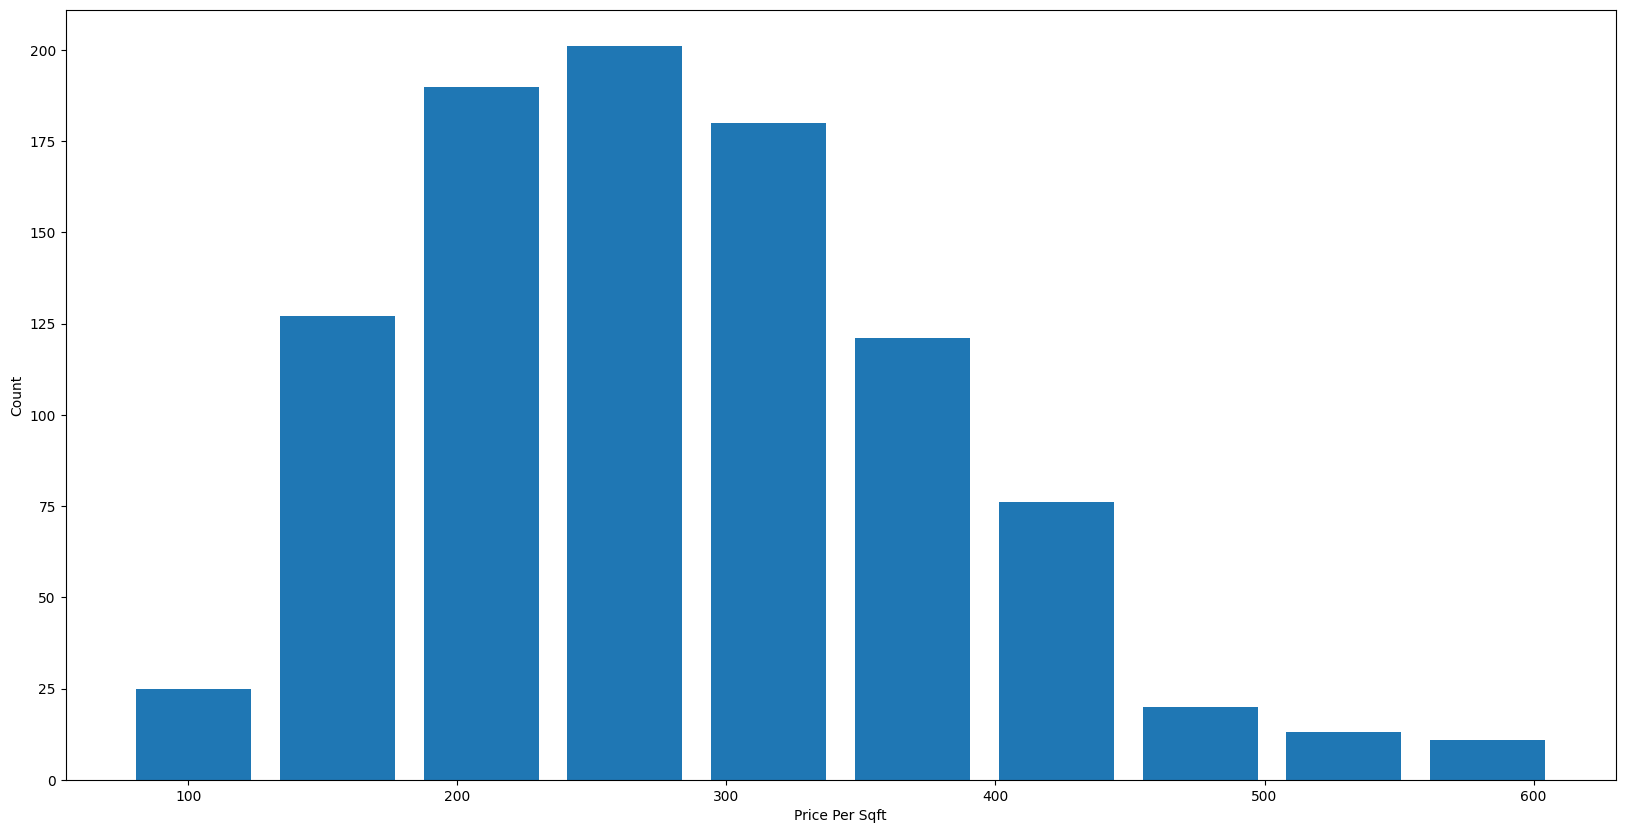

In [333]:
plt.hist(df6['Price Per Sqft'], rwidth=0.8)
plt.xlabel('Price Per Sqft')
plt.ylabel('Count')

In [334]:
# We see that the majority of the houses fall in $200-$300 range, but there are still some outliers to clean

df6['Bathrooms'].unique()

array([1, 4, 3, 2, 8, 6, 5, 0, 9])

In [335]:
df6[df6['Bathrooms'] > 5]

,Price,Bedrooms,Bathrooms,Square Footage,Community,Price Per Sqft
25,960000.0,4,8,2924.0,Balwin,328.317373
26,750000.0,3,6,2575.0,Balwin,291.262136
209,579998.0,5,6,2616.0,Eastwood,221.711774
483,1949900.0,5,6,4547.0,Parkview,428.832197
752,1499900.0,7,6,4588.0,other,326.918047
785,849888.0,5,6,2757.0,other,308.265506
808,1389900.0,4,6,3667.0,other,379.029179
968,839900.0,4,9,3445.0,other,243.802612


Text(0, 0.5, 'Count')

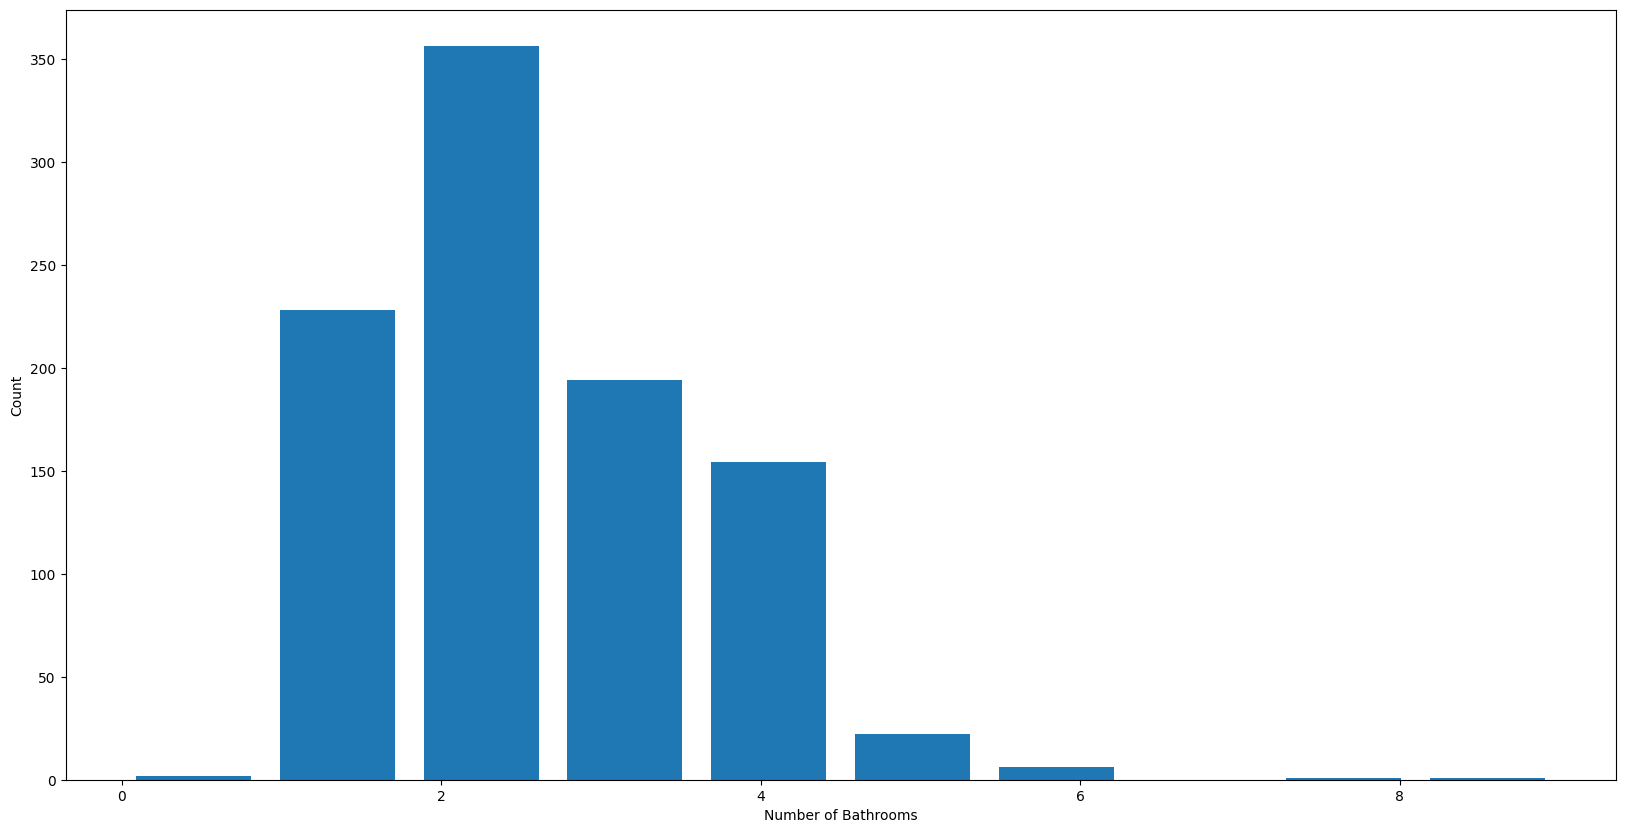

In [336]:
# As we can see, some houses have bathrooms that are two times the number of bedrooms, which is considered unusual
# We will get rid of such unusual datapoints

plt.hist(df6['Bathrooms'], rwidth=0.8)
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')

In [337]:
# We will specifically get rid of houses with more bathrooms than number of bedrooms plus 2 which are below

df6[df6['Bathrooms']>df6['Bedrooms']+2]

,Price,Bedrooms,Bathrooms,Square Footage,Community,Price Per Sqft
25,960000.0,4,8,2924.0,Balwin,328.317373
26,750000.0,3,6,2575.0,Balwin,291.262136
277,795995.0,1,4,4809.0,Glenwood,165.521938
968,839900.0,4,9,3445.0,other,243.802612


In [338]:
df7 = df6[df6['Bathrooms']<=df6['Bedrooms']+2]
df7.shape

(960, 6)

# Part 2 - Model Training:

We will use a linear regression model to train and test our dataset. We will then use k-fold cross validation as well as GridSearchCV to come up with the best algorithm and the best parameters.

In [339]:
# First we need to get rid of Price Per Sqft column that we no longer need

df8 = df7.drop('Price Per Sqft', axis='columns')
df8.head()

,Price,Bedrooms,Bathrooms,Square Footage,Community
0,215000.0,2,1,754.0,Alberta Avenue
1,224995.0,2,1,704.0,Alberta Avenue
2,149900.0,1,1,672.0,Alberta Avenue
3,378800.0,3,4,1395.0,Alberta Avenue
4,389000.0,3,3,1311.0,Alberta Avenue


In [340]:
# Using one-hot encoding for Community column

dummies = pd.get_dummies(df8['Community'])

dummies.head(3)

,Alberta Avenue,Athlone,Balwin,Baranow,Beacon Heights,Belgravia,Belmont,Belvedere,Bonnie Doon,Boyle Street,...,Queen Mary Park,Ritchie,Riverdale,Royal Gardens,Rundle Heights,Strathcona,Westmount,Westwood,Windsor Park,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [341]:
df9 = pd.concat([df8, dummies.drop('other', axis='columns')], axis='columns') # Dropping the last column in dummies df to avoid dummy variable trap
df9.head(3)

,Price,Bedrooms,Bathrooms,Square Footage,Community,Alberta Avenue,Athlone,Balwin,Baranow,Beacon Heights,...,Queen Alexandra,Queen Mary Park,Ritchie,Riverdale,Royal Gardens,Rundle Heights,Strathcona,Westmount,Westwood,Windsor Park
0,215000.0,2,1,754.0,Alberta Avenue,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,224995.0,2,1,704.0,Alberta Avenue,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,149900.0,1,1,672.0,Alberta Avenue,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [342]:
df10 = df9.drop('Community', axis='columns')
df10.head(2)

,Price,Bedrooms,Bathrooms,Square Footage,Alberta Avenue,Athlone,Balwin,Baranow,Beacon Heights,Belgravia,...,Queen Alexandra,Queen Mary Park,Ritchie,Riverdale,Royal Gardens,Rundle Heights,Strathcona,Westmount,Westwood,Windsor Park
0,215000.0,2,1,754.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,224995.0,2,1,704.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [343]:
df10.shape

(960, 62)

In [344]:
X = df10.drop('Price', axis='columns').replace({True: 1, False: 0})
X.head()

,Bedrooms,Bathrooms,Square Footage,Alberta Avenue,Athlone,Balwin,Baranow,Beacon Heights,Belgravia,Belmont,...,Queen Alexandra,Queen Mary Park,Ritchie,Riverdale,Royal Gardens,Rundle Heights,Strathcona,Westmount,Westwood,Windsor Park
0,2,1,754.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,704.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,672.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,1395.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,3,1311.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [345]:
y = df10['Price']
y.head()

,Price
0,215000.0
1,224995.0
2,149900.0
3,378800.0
4,389000.0


In [346]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [347]:
from sklearn.linear_model import LinearRegression

lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.9152226714663139

In [348]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

cv = ShuffleSplit(n_splits=5, test_size= 0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.89805884, 0.88770486, 0.89711059, 0.91890077, 0.88621626])

In [349]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

def find_best_model_using_gridsearchcv(X, y):
  algos = {
      'linear_regression' : {
          'model' : LinearRegression(),
          'params' : {}
      },
      'linear_regression_normalized' : {
          'model' : make_pipeline(MinMaxScaler(), LinearRegression()),
          'params' : {}
      },
      'lasso' : {
          'model' : Lasso(),
          'params' : {
              'alpha' : [1, 2],
              'selection' : ['random', 'cyclic']
          }
      },
      'decision_tree' : {
          'model' : DecisionTreeRegressor(),
          'params' : {
              'criterion' : ['squared_error', 'friedman_mse'],
              'splitter' : ['best', 'random']
          }
      }
  }

  scores = []
  cv = ShuffleSplit(n_splits=5, test_size= 0.2, random_state=0)
  for algo_name, config in algos.items():

    gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
    gs.fit(X, y)

    scores.append({
        'model' : algo_name,
        'best_score' : gs.best_score_,
        'best_params' : gs.best_params_
    })

  return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

find_best_model_using_gridsearchcv(X, y)

,model,best_score,best_params
0,linear_regression,0.897598,{}
1,linear_regression_normalized,0.897598,{}
2,lasso,0.897621,"{'alpha': 2, 'selection': 'cyclic'}"
3,decision_tree,0.719339,"{'criterion': 'squared_error', 'splitter': 'ra..."


In [350]:
def predict_price(location, bedroom, bath, sqft):
  loc_index = np.where(X.columns == location)[0][0]  # finding the column index of the wanted location

  x = np.zeros(len(X.columns))
  x[0] = bedroom
  x[1] = bath
  x[2] = sqft
  if loc_index >= 0:
    x[loc_index] = 1

  x_df = pd.DataFrame([x], columns=X.columns)

  return lr_clf.predict(x_df)[0] # see what happens without 0

In [351]:
predict_price('Alberta Avenue', 2, 2, 1000)

222383.0983589142

In [352]:
predict_price('Alberta Avenue', 3, 3, 1000)

223141.22538960224

In [353]:
predict_price('Belgravia', 2, 2, 1000)

592331.8847325109

In [354]:
predict_price('Belgravia', 3, 3, 1000)

593090.011763199

# Part 3 - Exporting our Model:
Now that our model is ready, we will save it to a Pickle File to later on be used on Python Flask Server.

We will also save the columns of X as a JSON file.

In [355]:
import pickle
with open('edmonton_home_prices_model.pickle', 'wb') as f:
  pickle.dump(lr_clf, f)

# checking to see if we are in Google Colab environment:
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# download the file to your local computer if in Google Colab
if IN_COLAB:
    files.download('edmonton_home_prices_model.pickle')
else:
    print("File saved as 'edmonton_home_prices_model.pickle'. Please download it manually if needed.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [356]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open('columns.json', 'w') as f:
  f.write(json.dumps(columns))

# download the file to your local computer if in Google Colab
if IN_COLAB:
    files.download('columns.json')
else:
    print("File saved as 'columns.json'. Please download it manually if needed.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>